In [1]:
import logging
import math
from pathlib import Path

import cv2
import fire
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from modules.manga109_annotation import Manga109Annotation
from modules.label_rect import label

In [3]:
path = '../../Dataset_Manga/Manga109/images/AisazuNihaIrarenai/006.jpg'

In [4]:
src = cv2.imread(path)[600:753,1301:1403]
src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

height, width = src.shape[:2]

edges = cv2.Canny(src_gray, 160, 200)

invert_gray_image = cv2.bitwise_not(src_gray)
sobel_x = cv2.Sobel(invert_gray_image, cv2.CV_64F, 1, 0)
sobel_y = cv2.Sobel(invert_gray_image, cv2.CV_64F, 0, 1)

magnitude, direction = cv2.cartToPolar(sobel_x, sobel_y)

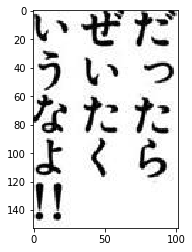

In [5]:
plt.imshow(src)

In [6]:
import math
import numpy as np
import logging

def get_swt(edges, sobel_x, sobel_y, direction, magnitude, height, width) -> np.ndarray:
    rays = []
    swt = np.full(edges.shape, np.Infinity)

    # Ignore error from divide by zero
    np.seterr(divide='ignore', invalid='ignore')

    step_x_g, step_y_g = sobel_x, sobel_y

    gradient_x_init = np.divide(step_x_g, magnitude)
    gradient_y_init = np.divide(step_y_g, magnitude)

    for y in range(height):
        for x in range(width):
            if edges[y][x] == 0:
                continue

            gradient_x = gradient_x_init[y, x]
            gradient_y = gradient_y_init[y, x]

            ray = [{'x': x, 'y': y}]
            i = 0

            while True:
                i += 1

                try:
                    cur_x = math.floor(x + gradient_x * i)
                    cur_y = math.floor(y + gradient_y * i)

                except ValueError:
                    # Catch Nan value when currently position reached to outside a image
                    break

                try:
                    ray.append({'x': cur_x, 'y': cur_y})

                    # IF still not found the another edge THEN go to next step
                    if edges[cur_y][cur_x] == 0:
                        continue

                    # Difference between the direction of start edge and another edge
                    # IF difference is exceed 90degree THEN ignore this ray
                    if abs(abs(round(np.degrees(direction[y, x])) - round(np.degrees(direction[cur_y, cur_x]))) - 180) > 90:
                        break

                    thickness = math.sqrt((cur_x - x) * (cur_x - x) + (cur_y - y) * (cur_y - y))
                    rays.append(ray)

                    for pos in ray:
                        swt[pos['y'], pos['x']] = min(thickness, swt[pos['y'], pos['x']])

                    break

                except IndexError:
                        break

    for ray in rays:
        median = np.median([swt[pos['y'], pos['x']] for pos in ray])

        for pos in ray:
            swt[pos['y'], pos['x']] = min(median, swt[pos['y'], pos['x']])

    logging.getLogger(__name__).info('Finished.')

    return swt


In [7]:
swt = get_swt(edges, sobel_x, sobel_y, direction, magnitude, height, width)

In [8]:
print(len(swt))

153


In [9]:
import logging

import numpy as np


def get_connected_components(swt: np.ndarray):
    class Label(object):
        def __init__(self, value):
            self.value = value
            self.parent = self
            self.rank = 0

    ld = {}

    def make_set(x):
        try:
            return ld[x]
        except KeyError:
            item = Label(x)
            ld[x] = item
            return item

    def find(item):
        if item.parent != item:
            item.parent = find(item.parent)

        return item.parent

    def union(x, y):
        """
        :param x:
        :param y:
        :return: root node of new union tree
        """
        x_root = find(x)
        y_root = find(y)
        if x_root == y_root:
            return x_root

        if x_root.rank < y_root.rank:
            x_root.parent = y_root
            return y_root
        elif x_root.rank > y_root.rank:
            y_root.parent = x_root
            return x_root
        else:
            y_root.parent = x_root
            x_root.rank += 1
            return x_root

    trees = {}
    label_map = np.zeros(shape=swt.shape, dtype=np.uint16)
    next_label = 1

    swt_ratio_threshold = 3.0

    for y in range(swt.shape[0]):
        for x in range(swt.shape[1]):

            sw_point = swt[y, x]
            if 0 < sw_point < np.Infinity:
                neighbors = [(y, x - 1),  # west
                             (y - 1, x - 1),  # northwest
                             (y - 1, x),  # north
                             (y - 1, x + 1)]  # northeast
                connected_neighbors = None
                neighbor_values = []

                for neighbor in neighbors:
                    try:
                        sw_n = swt[neighbor]
                        label_n = label_map[neighbor]
                    except IndexError:
                        continue
                    if label_n > 0 and sw_n / sw_point < swt_ratio_threshold and sw_point / sw_n < swt_ratio_threshold:
                        neighbor_values.append(label_n)
                        if connected_neighbors:
                            connected_neighbors = union(connected_neighbors, make_set(label_n))
                        else:
                            connected_neighbors = make_set(label_n)

                if not connected_neighbors:
                    trees[next_label] = make_set(next_label)
                    label_map[y, x] = next_label
                    next_label += 1
                else:
                    label_map[y, x] = min(neighbor_values)
                    trees[connected_neighbors.value] = union(trees[connected_neighbors.value], connected_neighbors)

    layers = {}
    for x in range(swt.shape[1]):
        for y in range(swt.shape[0]):
            if label_map[y, x] <= 0:
                continue

            item = ld[label_map[y, x]]
            common_label = find(item).value
            label_map[y, x] = common_label

            try:
                layer = layers[common_label]
            except KeyError:
                layers[common_label] = np.zeros(
                    shape=swt.shape, dtype=np.uint16)
                layer = layers[common_label]

            layer[y, x] = 1

    logging.getLogger(__name__).info('Finished.')

    return layers, label_map


In [10]:
connected_components, label_map = get_connected_components(swt)

In [11]:
print(len(connected_components))

34


In [12]:
import logging
import math

import numpy as np


def get_letters(swt: np.ndarray, connected_components: dict):
    swt_values, heights, widths, diameters, topleft_pts = [], [], [], [], []

    cnt = 0

    for label, layer in connected_components.items():
        # if cnt >= 100:
        #     break

        nz_y, nz_x = layer.nonzero()
        east, west, south, north = max(nz_x), min(nz_x), max(nz_y), min(nz_y)
        width, height = east - west, south - north

        if (height <= 5 or height >= 300) and (width <= 5 or width >= 300):
            continue
            
        diameter = math.sqrt(width * width + height * height)
        median_swt = np.median(swt[(nz_y, nz_x)])

        if diameter / median_swt <= 1 or diameter / median_swt > 20:
            continue

        swt_values.append(median_swt)
        heights.append(height)
        topleft_pts.append((north, west))
        widths.append(width)
        diameters.append(diameter)

        cnt += 1

    logging.getLogger(__name__).info('Finished.')

    return swt_values, heights, widths, diameters, topleft_pts


In [13]:
swt_values, heights, widths, diameters, topleft_pts = get_letters(swt, connected_components)

In [14]:
import logging
from typing import List, Tuple

import scipy.sparse
import scipy.spatial
import numpy as np


def get_words(swts: List[int], heights: List[int], widths: List[int], topleft_pts: Tuple[int, int]):
    swts_array = np.asarray([[i] for i in swts])
    heights_array = np.asarray([[i] for i in heights])
    topleft_pts_array = np.array(topleft_pts)

    if len(swts_array) == 0 or len(heights_array) == 0 or len(topleft_pts_array) == 0:
        return []

    swt_tree = scipy.spatial.KDTree(swts_array)
    stp = swt_tree.query_pairs(4)

    height_tree = scipy.spatial.KDTree(heights_array)
    htp = set(height_tree.query_pairs(4))

    isect = htp.intersection(stp)

    if len(isect) == 0:
        return []
    
    chains = []    
    for idx1, idx2 in isect:
        widest = max(widths[idx1], widths[idx2])
        distance = np.linalg.norm(topleft_pts_array[idx1] - topleft_pts_array[idx2])
        if distance >= widest * 2.5:
            continue
            
        added = False
        for chain in chains:
            if idx1 not in chain and idx2 in chain:
                chain.append(idx1)
                added = True
            elif idx1 in chain and idx2 not in chain:
                chain.append(idx2)
                added = True
                
        if not added:
            chains.append([idx1, idx2])
  
    words = []
    for chain in chains:
        word_swts = []
        east_word, west_word, south_word, north_word = 0, np.inf, 0, np.inf

        for idx in chain:
            north, west = topleft_pts[idx]
            south, east = north + heights[idx], west + widths[idx]

            east_word = max(east_word, east)
            west_word = min(west_word, west)
            south_word = max(south_word, south)
            north_word = min(north_word, north)

            word_swts.append(swts[idx])

        width, height = east_word - west_word, south_word - north_word

        words.append({
            'swt': np.median(word_swts),
            'height': height,
            'width': width,
            'topleft_pt': (north_word, west_word)
        })

    logging.getLogger(__name__).info('Finished.')

    return words


In [15]:
words = get_words(swt_values, heights, widths, topleft_pts)

In [16]:
widths, heights, topleft_pts = [], [], []
for datum in words:
    topleft_pts.append((datum['topleft_pt'][0], datum['topleft_pt'][1]))
    widths.append(datum['width'])
    heights.append(datum['height'])

img = src.copy()
for index in range(0, len(topleft_pts)):
    cv2.rectangle(
        img,
        (topleft_pts[index][1], topleft_pts[index][0]),
        (topleft_pts[index][1] + widths[index], topleft_pts[index][0] + heights[index]),
        (255,0,0),
        2
    )

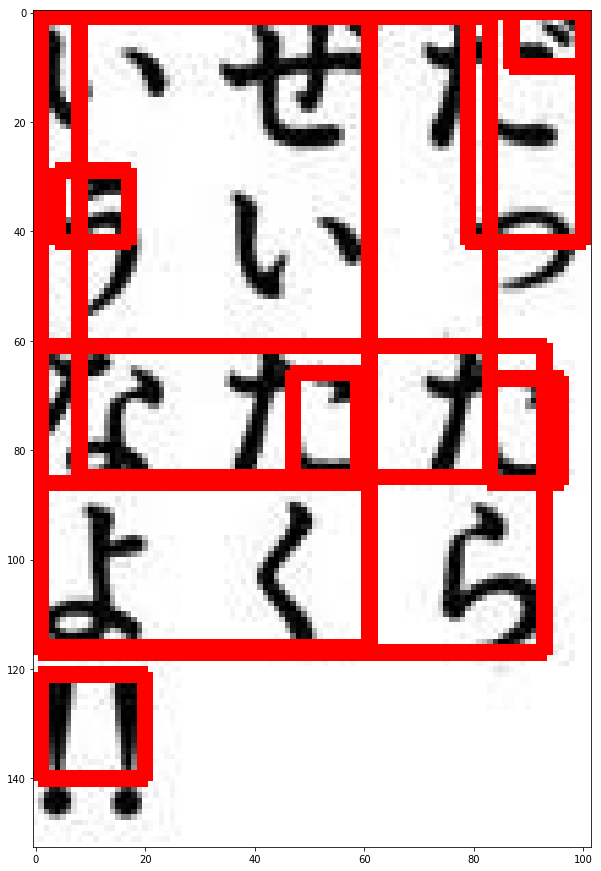

In [17]:
fig, ax = plt.subplots(figsize=(10, 20))
ax.imshow(img)